# EfficientNetB0 + metadata ensamble 

- The architecture aims to model images and tabular data
- The base model used for images is EfficientNet b0 with noisy student weights
- Trained with AdamW + cosine decay 
- Performed an ensamble using 5-fold CV

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import os
import gc
import cv2
from tqdm import tqdm
import seaborn as sns
import tensorflow_addons as tfa
import math

2021-10-22 05:38:52.609056: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

2021-10-22 05:38:57.420176: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-22 05:38:57.423190: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-22 05:38:57.465193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 05:38:57.465916: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-22 05:38:57.465997: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-22 05:38:57.502887: I tensorflow/stream_executor/platform/def

In [5]:
SEED = 42
np.random.seed(SEED)
IMAGE_SIZE = (224, 224)

BATCH_SIZE = 32
EPOCHS = 20
FOLDS = 5

if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  datapath = "gdrive/MyDrive/PAWPULARITY"
else:
  datapath  = ".."

INPUT_DIR = os.path.join(datapath, "input")
OUTPUT_DIR = os.path.join(datapath, "working")
TRAIN_IMAGES_DIR = os.path.join(INPUT_DIR, "petfinder-pawpularity-score", 'train')
TRAIN_DS = os.path.join(INPUT_DIR, "petfinder-pawpularity-score", 'train.csv')
TEST_IMAGES_DIR = os.path.join(INPUT_DIR, "petfinder-pawpularity-score", 'test')
TEST_DS = os.path.join(INPUT_DIR, "petfinder-pawpularity-score", 'test.csv')
SUBMISSION_DS = os.path.join(INPUT_DIR, "petfinder-pawpularity-score", 'sample_submission.csv')

if lazy_submit:
    TRAINED_WEIGHTS_DIR = os.path.join(INPUT_DIR,  'weights-pawpularity')
else: 
    TRAINED_WEIGHTS_DIR = OUTPUT_DIR
    
weights =  os.path.join(INPUT_DIR, "efficientnet-noisy-student-b0", "efficientnetb0_noisy_student_notop.h5")

In [7]:
train_ds = pd.read_csv(TRAIN_DS)
train_ds['Pawpularity'] = train_ds['Pawpularity']/100.0
test_ds = pd.read_csv(TEST_DS)
subm_ds = pd.read_csv(SUBMISSION_DS)
meta_cols = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 
             'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
train_ds.shape

(9912, 14)

## Useful functions

In [13]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, img_dir, 
                 batch_size, tab_columns,
                 id, target, is_train,
                 input_size = (224, 224),
                 shuffle = True):
        
        self.df = df.copy()
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle    
        self.n = len(self.df)
        self.tab_columns = tab_columns
        self.target = target
        self.id = id
        self.is_train = is_train
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, index):
        this_ds = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]
        images = []
        for img_id in list(this_ds[self.id].values):
            img = cv2.imread(f"{self.img_dir}/{img_id}.jpg")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMAGE_SIZE, interpolation=cv2.INTER_LINEAR)
            img = np.array(img, dtype='float32') 
            # ./ 255.0 EfficientNet models expect their inputs to be float tensors of pixels with values in the [0-255] range
            images.append(img)
        if self.is_train:
            return [np.array(images), this_ds[self.tab_columns].values],this_ds[self.target].values
        else:
            return [np.array(images), this_ds[self.tab_columns].values]

## Build the model

In [14]:
NCOL = len(meta_cols)
INPUT_SHAPE = (*IMAGE_SIZE, 3)

optimizer = tfa.optimizers.AdamW(lr=1e-3, weight_decay=1e-4)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_root_mean_squared_error",
    patience = 2,
    factor = 0.5,
    verbose = 1,
    mode = 'min'
)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error', patience=3
)

class CosineAnnealingLearningRateSchedule(tf.keras.callbacks.Callback):
    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lrates = list()

    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = math.floor(n_epochs/n_cycles)
        cos_inner = (math.pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        return lrate_max/2 * (math.cos(cos_inner) + 1)

    def on_epoch_begin(self, epoch, logs=None):
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        self.lrates.append(lr)

ca = CosineAnnealingLearningRateSchedule(EPOCHS, EPOCHS/5, 1e-3)

rmse = tf.keras.metrics.RootMeanSquaredError()


def get_checkpoint(idx):
    return tf.keras.callbacks.ModelCheckpoint(os.path.join(OUTPUT_DIR, f'efficientnetb0_{idx}.h5'), 
                                                    monitor='val_root_mean_squared_error', verbose = 1, 
                                                    save_best_only=True, mode='min', save_weights_only = True)


def create_model():

    CONV_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 2.0,
        'mode': 'fan_out',
        'distribution': 'normal'
        }
    }

    conv_base = tf.keras.applications.efficientnet.EfficientNetB0(
        weights = weights,
        include_top = False,
        input_tensor=keras.Input(shape = INPUT_SHAPE))

    conv_base.trainable = False

    def conv2d_block(mod, filters):
        out = layers.Conv2D(filters, kernel_size  = (1, 1),
                          padding='same',
                          kernel_initializer = CONV_KERNEL_INITIALIZER)(mod)
        out = layers.BatchNormalization()(out)
        out = layers.Activation("swish")(out)
        return out

    inp = tf.keras.Input(shape=INPUT_SHAPE)
    out = conv_base(inp)
    out = conv2d_block(out, 640)
    out = conv2d_block(out, 320)
    out = conv2d_block(out, 128)
    out = layers.GlobalAveragePooling2D()(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dropout(0.1)(out) 

    meta_input = keras.Input(shape = (NCOL,))
    concat = layers.Concatenate(axis = 1)([out, meta_input])
    concat = layers.Dense(128)(concat) 
    concat = layers.PReLU()(concat)
    concat = layers.Dropout(0.1)(concat) 
    concat = layers.Dense(64)(concat) 
    concat = layers.PReLU()(concat)
    concat = layers.Dropout(0.1)(concat) 
    concat = layers.Dense(1, activation = "sigmoid")(concat)
    model = tf.keras.Model([inp, meta_input], concat)

    return model
    
    
def get_model():
    model = create_model()
    model.compile(loss = "binary_crossentropy", 
        optimizer = optimizer,
        metrics=[rmse])
    return model

2021-10-22 05:39:02.712630: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-22 05:39:02.712895: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-22 05:39:02.713225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 05:39:02.713868: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-1

In [15]:
check_model = get_model()
check_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
efficientnetb0 (Functional)     (None, 7, 7, 1280)   4049571     input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 7, 7, 640)    819840      efficientnetb0[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 7, 7, 640)    2560        conv2d[0][0]                     
______________________________________________________________________________________________

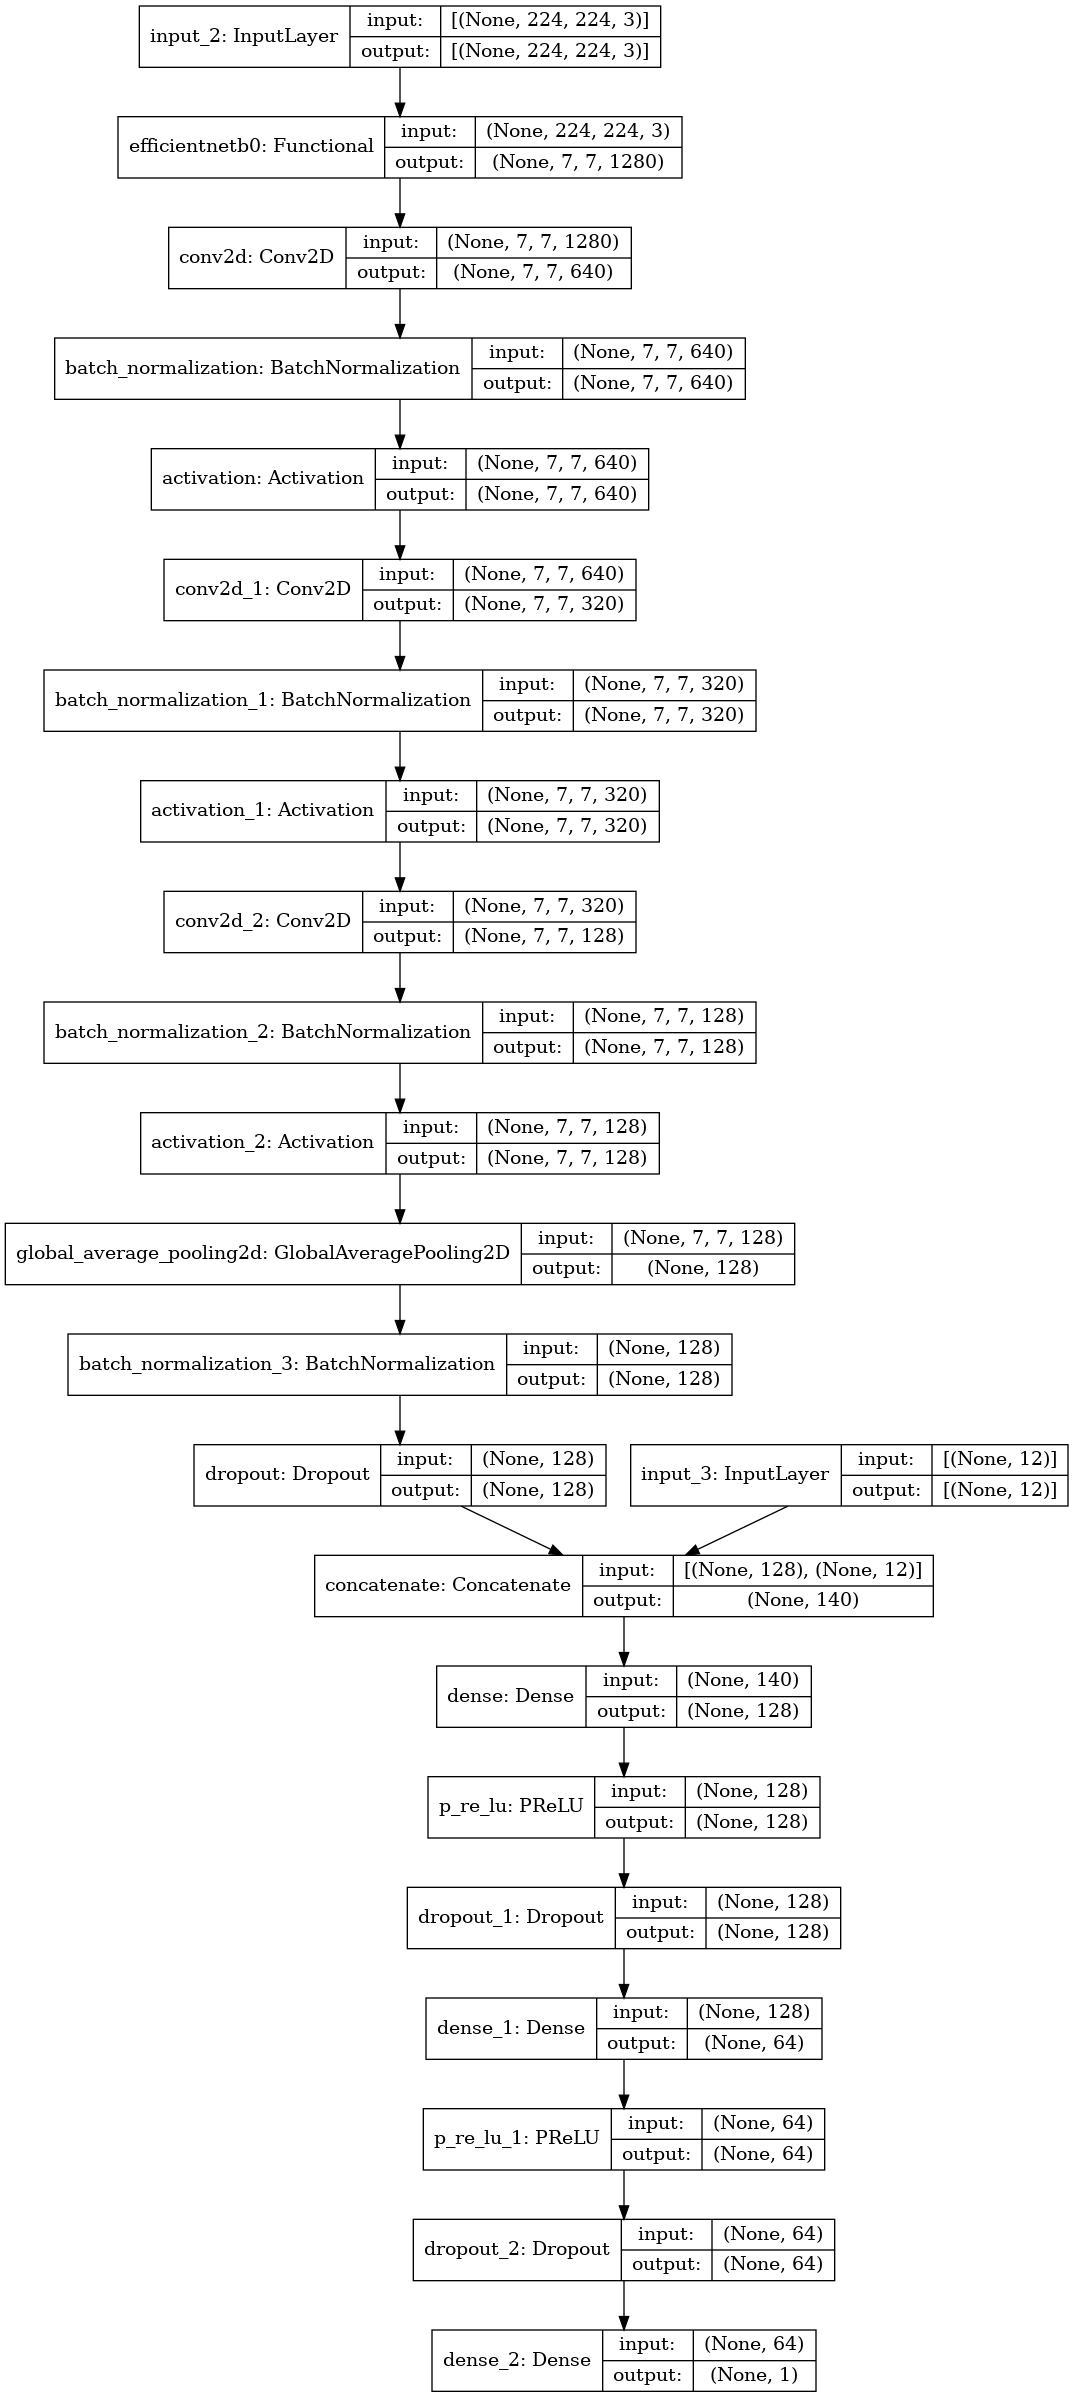

In [16]:
tf.keras.utils.plot_model(check_model, show_shapes=True)

## Train the model

In [17]:
kf = KFold(n_splits = FOLDS, shuffle = True, random_state = SEED)

def train():
   
    models = []
    histories = []
    for idx, (train_idx, val_idx) in enumerate(kf.split(train_ds)):
        
        print(f'\n----- RUN: {idx} ------')
        
        params = dict(batch_size=32, tab_columns=meta_cols, id="Id", target="Pawpularity", is_train = True)
        train_gen = CustomDataGen(img_dir = TRAIN_IMAGES_DIR, df=train_ds.iloc[train_idx], **params)
        val_gen = CustomDataGen(img_dir = TRAIN_IMAGES_DIR, df=train_ds.iloc[val_idx], **params)
        
        model = get_model()
        
        checkpoint = get_checkpoint(idx)

        history = model.fit(train_gen,
                            validation_data = val_gen,
                            epochs = EPOCHS, 
                            callbacks = [checkpoint, es, ca],
                            max_queue_size = 3 * BATCH_SIZE)
                            
        models.append(model)
        histories.append(history.history)
        gc.collect()
        
    return models,histories


----- RUN: 0 ------


2021-10-22 05:39:12.720927: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-22 05:39:12.725462: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000185000 Hz


Epoch 1/20


2021-10-22 05:39:18.943935: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-22 05:39:19.809519: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-22 05:39:19.866223: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


248/248 [==============================] - 163s 607ms/step - loss: 0.6752 - root_mean_squared_error: 0.2119 - val_loss: 0.6629 - val_root_mean_squared_error: 0.2085

Epoch 00001: val_root_mean_squared_error improved from inf to 0.20846, saving model to ../working/efficientnetb0_0.h5
Epoch 2/20
248/248 [==============================] - 110s 445ms/step - loss: 0.6508 - root_mean_squared_error: 0.1869 - val_loss: 0.6451 - val_root_mean_squared_error: 0.1872

Epoch 00002: val_root_mean_squared_error improved from 0.20846 to 0.18717, saving model to ../working/efficientnetb0_0.h5
Epoch 3/20
248/248 [==============================] - 109s 439ms/step - loss: 0.6447 - root_mean_squared_error: 0.1807 - val_loss: 0.6430 - val_root_mean_squared_error: 0.1845

Epoch 00003: val_root_mean_squared_error improved from 0.18717 to 0.18446, saving model to ../working/efficientnetb0_0.h5
Epoch 4/20
248/248 [==============================] - 110s 444ms/step - loss: 0.6395 - root_mean_squared_error: 0.1735

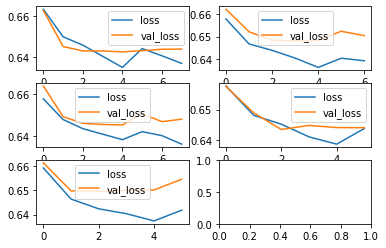

AVG RMSE: 0.18321689069271088


In [18]:
if not lazy_submit:
    models,histories = train()
    evals = np.mean([np.min(histories[i]['val_root_mean_squared_error']) for i in range(FOLDS)])
    
    fig,ax = plt.subplots(3,2)
    for i in range(FOLDS):
        ax = ax.flatten()
        ax[i].plot(histories[i]['loss'], label= 'loss')
        ax[i].plot(histories[i]['val_loss'], label = 'val_loss')
        ax[i].legend()
    plt.show()
    
else:
    models = []
    evals = 0
    for idx, (train_idx, val_idx) in enumerate(kf.split(train_ds)):
        params = dict(img_dir=TRAIN_IMAGES_DIR, batch_size=BATCH_SIZE, tab_columns=meta_cols, id="Id", target="Pawpularity", is_train = True, shuffle  = False)
        val_gen = CustomDataGen(df=train_ds.iloc[val_idx], **params)
        model = get_model()
        model.load_weights(os.path.join(TRAINED_WEIGHTS_DIR, f'efficientnetb0_{idx}.h5'))
        models.append(model)
        evals += model.evaluate(val_gen, 
                                    max_queue_size = 3 * BATCH_SIZE)[1] 
    evals /= FOLDS

print("AVG RMSE:", evals)

# Submission

In [19]:
predictions = []
params = dict(img_dir = TEST_IMAGES_DIR, batch_size = BATCH_SIZE, tab_columns = meta_cols, id = "Id", target = "Pawpularity", is_train = False, shuffle = False)
test_gen = CustomDataGen(df = test_ds, **params)

for i in tqdm(range(FOLDS)):
    predictions.append(models[i].predict(test_gen))
    
subm_ds["Pawpularity"] =  100 * np.array(predictions).mean(axis = 0)
subm_ds.to_csv("submission.csv", index = False)

100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


In [20]:
subm_ds.head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,47.230034
1,43a2262d7738e3d420d453815151079e,53.022945
2,4e429cead1848a298432a0acad014c9d,51.799053
3,80bc3ccafcc51b66303c2c263aa38486,50.871216
4,8f49844c382931444e68dffbe20228f4,47.199284
